# Quantumquipu Challenge 
### Integrantes : 
                - Ivan Miranda. 

                - Cesar Torrico. 
                 
                - Javier Feijóo.
## Reto: Decodificar y Clasificar
codificar los archivos en al menos dos formas diferentes en un circuito cuántico.

Diseña un circuito cuántico variacional para cada una de las codificaciones

**El ganador será el que llegue a obtener el mejor accuracy con su modelo propuesto.**

In [63]:
import numpy as np
from numpy import linalg 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals
from sklearn.svm import SVC
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, PauliFeatureMap, StatePreparation, RYGate, EfficientSU2
from qiskit.algorithms.optimizers import COBYLA
from qiskit import QuantumCircuit 
from qiskit.circuit import  Parameter, ParameterVector
from qiskit.primitives import Sampler
from matplotlib import pyplot as plt
from IPython.display import clear_output
import time
import numpy as np
from qiskit_machine_learning.algorithms.classifiers import VQC


### Datasets

In [2]:
train = pd.read_csv("challenge_train.csv")
test = pd.read_csv("challenge_test.csv")
train.drop('Unnamed: 0', axis=1, inplace=True)
test.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
train.head()

,F1,F2,F3,F4,Target
0,-0.291592,1.854606,-0.226004,1.694754,1
1,0.327501,1.584748,-1.300541,0.471729,1
2,0.227985,1.512023,-0.646984,-0.743707,1
3,-0.453525,1.819041,-0.870957,-1.452390,1
4,-1.480420,1.278968,-1.193171,-0.000952,1


### Dimensiones de datasets  
**Train :** - Features = 4 \
            - Entries = 800 \
**Test :**  - Featues = 4\
            - Entries 200\

Matemáticamente podemos describir $\phi(x)$ como una relacion clásica entre los conjuntos $\chi $  y $T$  (Target) . 
El primer paso para un algoritmo de clasificación es transformar la informacion clásica en estados cuánticos que contengan esa información. Este proceso llamado encoding transforma el conjunto $\chi \rightarrow \left|\left.\chi(\vec{x})\right\rangle \right. $

In [102]:
# separamos los conjuntos X e T
target_name = 'Target'
target_name = 'Target'
y_train = train[target_name]
X_train = train.drop(target_name, axis=1)
y_test = test[target_name]
X_test = test.drop(target_name, axis=1) 
X_train = MinMaxScaler().fit_transform(X_train)
X_test = MinMaxScaler().fit_transform(X_test)
train_features, test_features, train_labels, test_labels = X_train,X_test,y_train, y_test

# Encoding

Vamos a explorar varios métodos de encoding.\

Tanto como en el Angular Encoding como en Encoding arbitrarios cada feature $N=4$ del dataset se parametriza en N gates sobre n qubits donde $n<=N$.  Inicialmente usamos los feature maps de Qiskit para hacer el encoding de los datos 

## ZZFeatureMap 
Toma los 4 parámetros del vector y los asigna a 4 parámetros de compuertas , se puede repetir la compuerta\
 en reps = # numero de repeticione

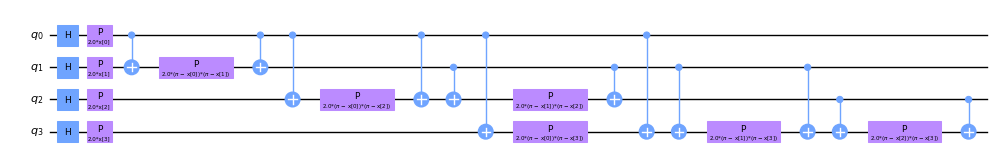

In [35]:
num_features = X_train.shape[1]

ZZfeature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ZZfeature_map.decompose().draw(output="mpl",fold=-1, scale=0.5)

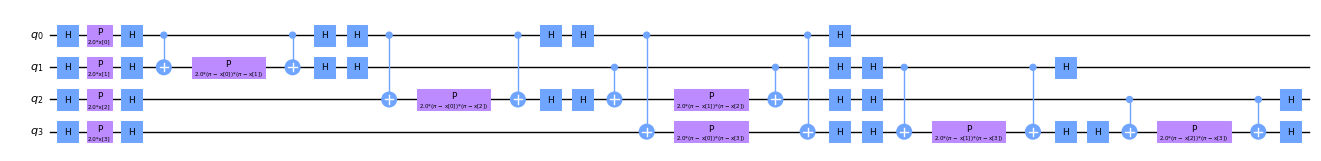

In [37]:
Paulifeature_map = PauliFeatureMap(feature_dimension=num_features,alpha=2.0, reps=1,entanglement='full',paulis=['Z', 'XX'])
Paulifeature_map.decompose().draw(output="mpl",fold=-1, scale=0.5)

Angular Encoding 

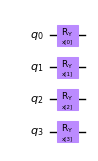

In [60]:
xparam = ParameterVector('x', length= 4)
AmplitudEncoding = QuantumCircuit(4)
AmplitudEncoding.ry(xparam[0], 0)
AmplitudEncoding.ry(xparam[1], 1)
AmplitudEncoding.ry(xparam[2], 2)
AmplitudEncoding.ry(xparam[3], 3)
AmplitudEncoding.draw(output="mpl",fold=-1, scale=0.5)

### Parameters  Gate
El siguiente paso en el circuito de clasificación es el Gate de Anzat donde va a estar el vector de parámetros $\vec{\theta }$\
el cual sera luego optimizado para la clasificación. El Anzat es un Gate Unitario el cual aplicado a un estado cuántico introduce la információn del vector de parámatros $ \left|\left.\chi(\vec{x},\vec{\theta })\right\rangle \right.= U(\vec{\theta }) \left|\left.\chi(\vec{x})\right\rangle \right. $


Real Amplitud Anzat 

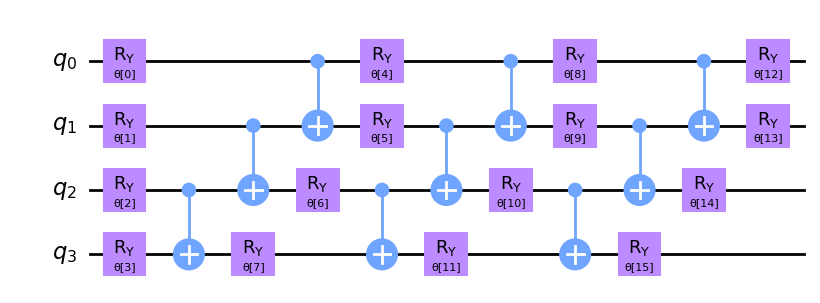

In [62]:
RAansatz = RealAmplitudes(num_qubits=num_features, reps=3)
RAansatz.decompose().draw(output="mpl", fold=20)

EfficientSU2

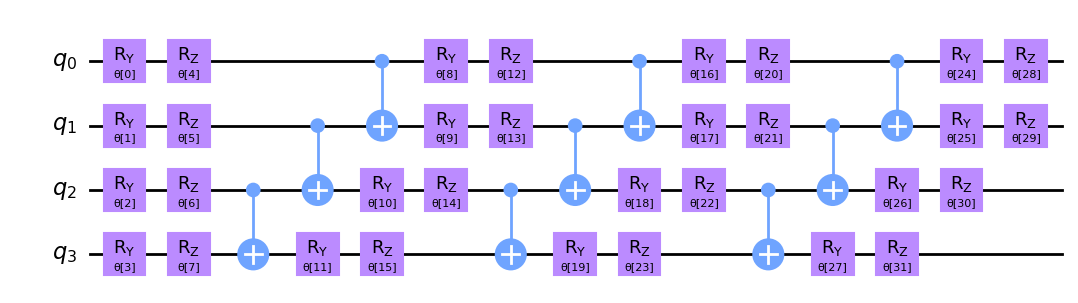

In [67]:
EFFSU2ansatz = EfficientSU2(num_qubits=num_features, reps=3,entanglement='reverse_linear' )
EFFSU2ansatz.decompose().draw(output="mpl", fold=20)

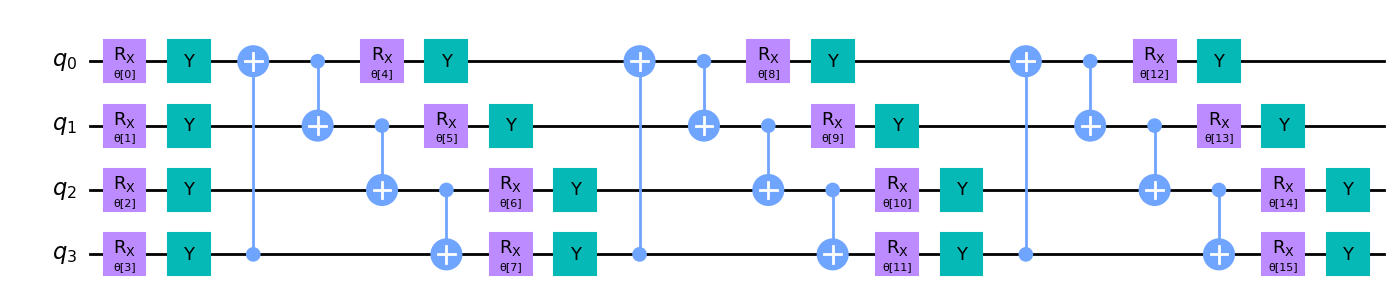

In [68]:
EFFSU2ansatz2 = EfficientSU2(num_qubits=num_features,su2_gates=['rx', 'y'], reps=3,entanglement='circular' )
EFFSU2ansatz2.decompose().draw(output="mpl", fold=20)

De esta forma podemos ver que nuestro circuito tiene la siguiente forma 

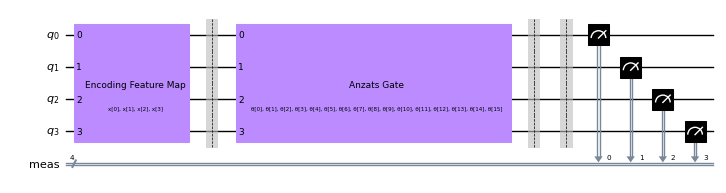

In [99]:
qc = QuantumCircuit(4)
EncodingGate = Paulifeature_map.to_gate(label= "Encoding Feature Map" )
qc.append(EncodingGate,qc.qubits)
qc.barrier()
AnzatGate = RAansatz.to_gate(label= "Anzats Gate")
qc.append(AnzatGate,qc.qubits)
qc.measure_all()
qc.draw(output="mpl",fold=-1, scale=0.5)

### Optimizadores 

In [100]:
optimizer = COBYLA(maxiter=100)
# Escribir una lista con diferentes optimizadores para pobrar 
sampler = Sampler()

### Plotter 

In [101]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Valor de la función objetivo frente a la iteración")
    plt.xlabel("Iteración")
    plt.ylabel("Valor de la función objetivo")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [104]:
vqc = VQC(
    sampler=sampler,
    feature_map=ZZfeature_map,
    ansatz=RAansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

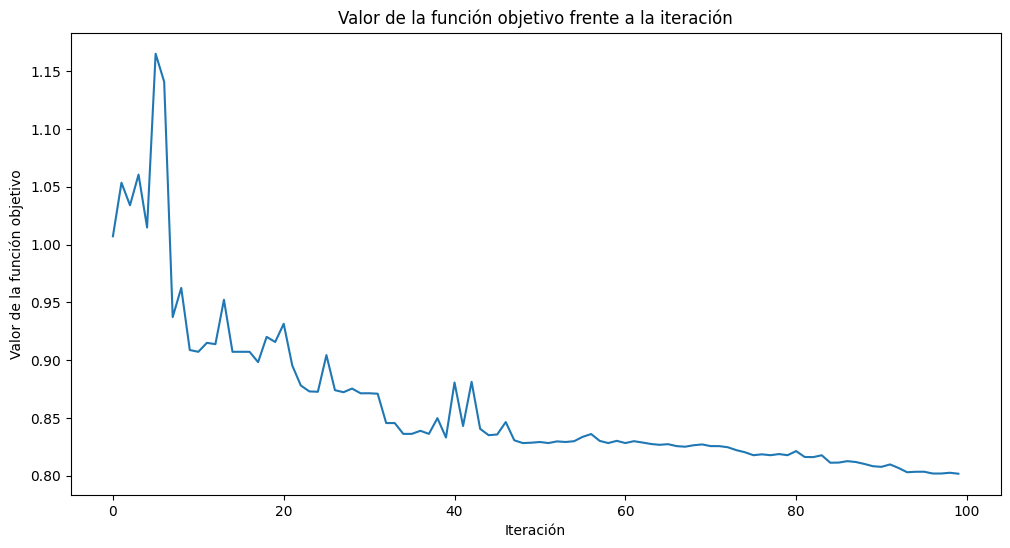

Training time: 1906 seconds


In [105]:
# clear objective value history
objective_func_vals = []

# Convert pandas Series to numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [ ]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.4f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.4f}")